In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:


def plot_maze_and_traj_xy(s, n_trajs, wall_color='black', show_init=True):
    maze =  np.array([
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
                    [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
                    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
                    [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
                    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
                    [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1],
                    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
                    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
                    [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1],
                    [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                ]   )         # 2D grid of 0 (free) / 1 (wall)
    unit = 4      # e.g., 4.0
    offx, offy = 4, 4

    fig, ax = plt.subplots()

    # draw walls in continuous world coords
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == 1:
                cx = j * unit - offx
                cy = i * unit - offy
                ax.add_patch(Rectangle((cx - unit/2, cy - unit/2), unit, unit,
                                       facecolor=wall_color, edgecolor='black'))
            else:
                cx = j * unit - offx
                cy = i * unit - offy
                ax.add_patch(Rectangle((cx - unit/2, cy - unit/2), unit, unit,
                                        facecolor="white", edgecolor="white"))


    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("yellow_red", ["yellow", "red"])
    cmap = LinearSegmentedColormap.from_list(
        "blue_green_orange",
        ["#0151AD", "#00CC6DB3", "#FFB108", "#FF0000CF"]  # bright blue → vivid green → warm orange
    )
    # Normalize color
    norm = plt.Normalize(vmin=1, vmax=n_trajs)
    for i in range(s.shape[0]):
        plt.plot(s[i, :, 0].cpu().detach(), s[i, :, 1].cpu().detach(), color=cmap(norm(i)), linewidth=5)
        if show_init:   
            plt.scatter(s[i, 0, 0].cpu().detach(), s[i, 0, 1].cpu().detach(), color=cmap(norm(i)), s=100, zorder=11+i *2, edgecolor='black')

            plt.text(
                s[i, 0, 0].cpu().detach(),
                s[i, 0, 1].cpu().detach(),
                str(i+1),              # the number
                color='black',
                ha='center',         # horizontal alignment
                va='center',         # vertical alignment
                fontsize=8,          # adjust as needed
                zorder=11+i *2+1           # above scatter
            )
    # nice axes
    x_min = -offx - unit/2
    x_max = (maze.shape[1] - 1) * unit - offx + unit/2
    y_min = -offy - unit/2
    y_max = (maze.shape[0] - 1) * unit - offy + unit/2
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)
    # turn off axes
    ax.set_xticks([])
    ax.set_yticks([])

In [3]:
def unnormalize(x, max, min, eps=1e-4):
    '''
        x : [ -1, 1 ]
    '''
    if x.max() > 1 + eps or x.min() < -1 - eps:
        # print(f'[ datasets/mujoco ] Warning: sample out of range | ({x.min():.4f}, {x.max():.4f})')
        x = np.clip(x, -1, 1)

    ## [ -1, 1 ] --> [ 0, 1 ]
    x = (x + 1) / 2.

    return x * (max - min) + min
def normalize(x, maxs, mins):
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins)
    ## [ -1, 1 ]
    x = 2 * x - 1
    return x

mins = torch.tensor([-1.26, -1.18])
maxs = torch.tensor([53.24, 37.29])

### Load Saved Trajectory Data

In [4]:
ALL_sub_samples = torch.load('task_online.pt')
samples_size = ALL_sub_samples.shape[0]
n_trajs = 20

In [5]:
A = torch.tensor([-0.95, 0.95])
B = torch.tensor([0.95, -0.95])
R = torch.tensor([0.2, -0.52])

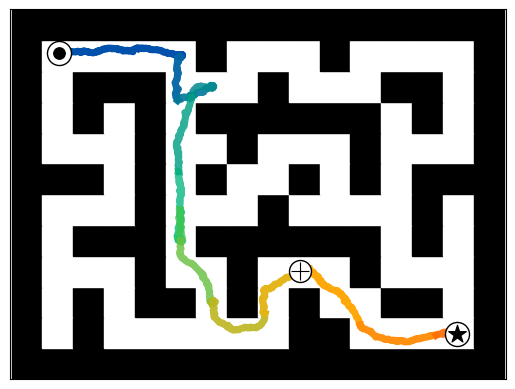

In [7]:
for idx in range(1):
    tra = ALL_sub_samples[750][-1].reshape(20*64, -1)
    tra = unnormalize(tra, maxs, mins)

    plot_maze_and_traj_xy(tra.reshape(-1, 64, 2), n_trajs, wall_color='black', show_init=False)
    # plot a circle at the start
    xA, yA = map(float, unnormalize(A.cpu(), maxs, mins)[:2])
    xB, yB = map(float, unnormalize(B.cpu(), maxs, mins)[:2])
    xR, yR = map(float, unnormalize(R.cpu(), maxs, mins)[:2])

    plt.scatter(xA, yA, s=300, marker='o',
            facecolors='white', edgecolors='black', linewidths=1, zorder=10)
    plt.scatter(xA, yA, s=70, marker='o',
            c='black', linewidths=0.8, zorder=11)

    plt.gca().set_aspect('equal', adjustable='datalim')

    plt.scatter(xB, yB, s=300, marker='o',
            facecolors='white', edgecolors='black', linewidths=1, zorder=10)
    plt.scatter(xB, yB, s=180, marker='*',
            c='black', linewidths=0.8, zorder=11)


    plt.scatter(xR, yR, s=250, marker='o',
            facecolors='white', edgecolors='black', linewidths=1, zorder=10)
    plt.scatter(xR, yR, s=150, marker='+',
            c='black', linewidths=0.8, zorder=11)
    plt.show()

### Calculate Success Rate

In [ ]:
import numpy as np
from math import floor


def point_in_wall(point):
    maze =  np.array([
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
                    [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
                    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
                    [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
                    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
                    [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1],
                    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
                    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
                    [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1],
                    [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                ]   )         # 2D grid of 0 (free) / 1 (wall)
    unit = 4      # e.g., 4.0
    offx, offy = 4, 4
    x, y = point
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == 1:
                cx = j * unit - offx
                cy = i * unit - offy
                if (abs(x - cx) <= unit/2) and (abs(y - cy) <= unit/2):
                    return True
    return False
import numpy as np

def points_in_walls(points):
    maze =  np.array([
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
                    [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1],
                    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
                    [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
                    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
                    [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1],
                    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
                    [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
                    [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1],
                    [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                ]   )         # 2D grid of 0 (free) / 1 (wall)
    unit = 4      # e.g., 4.0
    offx, offy = 4, 4
    pts = np.asarray(points)                # [..., 2]
    flat_pts = pts.reshape(-1, 2)           # [N, 2]
    mask = np.zeros(len(flat_pts), dtype=bool)

    # loop over walls
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == 1:
                cx = j * unit - offx
                cy = i * unit - offy
                inside_x = np.abs(flat_pts[:, 0] - cx) < unit/2
                inside_y = np.abs(flat_pts[:, 1] - cy) < unit/2
                mask |= (inside_x & inside_y)   # mark any point inside this wall

    return mask.reshape(pts.shape[:-1])


In [ ]:
ALL_sub_samples = torch.load('task_online.pt')

In [ ]:
# traj not in wall
all_sub_trajs = ALL_sub_samples[:, -1].reshape(samples_size, 20, 64, 2).clone()
all_sub_trajs = unnormalize(all_sub_trajs.reshape(-1, 64, 2), maxs, mins).reshape(samples_size, 20, 64, 2)
traj_in_wall = points_in_walls(all_sub_trajs.reshape(-1, 2)).reshape(samples_size, 20, 64).any(-1).any(-1)


# traj are linked without passing through walls
all_sub_trajs = ALL_sub_samples[:, -1].reshape(samples_size, 20, 64, 2).clone()
all_sub_trajs = unnormalize(all_sub_trajs.reshape(-1, 64, 2), maxs, mins).reshape(samples_size, 20, 64, 2)
last_end = all_sub_trajs[:, 1:, 0, :]
last_start = all_sub_trajs[:, :-1, -1, :]
dist = (last_end - last_start).norm(dim=-1)
traj_through_wall = (dist > 0.45).any(-1).numpy()

# check if A and B close enough to the trajectory
all_sub_trajs = ALL_sub_samples[:, -1].reshape(samples_size, 20, 64, 2).clone()
all_sub_trajs = unnormalize(all_sub_trajs.reshape(-1, 64, 2), maxs, mins).reshape(samples_size, 20, 64, 2)
start = all_sub_trajs[:, 0, 0, :]
end = all_sub_trajs[:, -1, -1, :]
unnormalised_A = unnormalize(A.cpu(), maxs, mins)
unnormalised_B = unnormalize(B.cpu(), maxs, mins)
unnormalised_R = unnormalize(R.cpu(), maxs, mins)
dist_A = (start - unnormalised_A).norm(dim=-1).numpy()
dist_B = (end - unnormalised_B).norm(dim=-1).numpy()
dist_R = (all_sub_trajs - unnormalised_R).norm(dim=-1).min(-1)[0].min(-1)[0].numpy()

success = (~traj_in_wall) & (~traj_through_wall.astype(bool)) & (dist_A < 0.45) & (dist_B < 0.45)   #& (dist_R < 0.45)   # uncomment this to check if the path go through R
